<a href="https://colab.research.google.com/github/RodrigodeFeo/8DTS/blob/main/Trabalho_Integrado_CV_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install opencv-python-headless
!pip install mediapipe
!pip install dlib
!pip install face_recognition
!pip install google-colab
!pip install deepface
!pip install facenet-pytorch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.3

In [35]:
#Para simular um cadastro previo vamos fazer o upload da foto do cliente que sera utilizada para a comparacao com a lida pela camera
import os
from google.colab import files

# Cria uma interface para o upload de arquivos
uploaded = files.upload()

# Listar os nomes dos arquivos que foram enviados
for filename in uploaded.keys():
    print(f'Arquivo {filename} enviado com sucesso!')

# Renomeie o arquivo
if os.path.exists(filename):
    os.rename(filename, "foto_cadastro.jpg")


Saving fotorosto.jpg to fotorosto.jpg
Arquivo fotorosto.jpg enviado com sucesso!


In [6]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

--2024-07-28 23:29:12--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  15.5MB/s    in 3.9s    

2024-07-28 23:29:17 (15.5 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


In [7]:
import os
from google.colab import output

def file_exists(file_path):
    file_path ='/content/captured_frame_det.jpg'
    return os.path.exists(file_path)

# Registra a função Python para chamada pelo JavaScript
output.register_callback('notebook.file_exists', file_exists)


In [4]:
from IPython.display import display, Javascript, HTML

HTML('''
<video autoplay playsinline id="video" width="640" height="480"></video>
<button id="captureButton">Capturar Frame</button>
<button id="stopButton">Parar Webcam</button>
<button id="startButton">Iniciar Webcam</button>
<script>
  const video = document.getElementById('video');
  const button = document.getElementById('captureButton');
  let stream;

  async function setupCamera() {
    stream = await navigator.mediaDevices.getUserMedia({ video: true });
    video.srcObject = stream;
    await new Promise((resolve) => (video.onloadedmetadata = resolve));
    video.play();
  }

  async function stopCamera() {
    if (stream) {
      stream.getTracks().forEach((track) => track.stop());
      stream.srcObject = null;
      stream = null;
    }
  }

  async function startCamera() {
    await stopCamera();
    await setupCamera();
  }


  function captureFrame() {
    const canvas = document.createElement('canvas');
    canvas.width = video.videoWidth;
    canvas.height = video.videoHeight;
    const context = canvas.getContext('2d');
    context.drawImage(video, 0, 0, canvas.width, canvas.height);
    const data = canvas.toDataURL('image/jpeg');
    google.colab.kernel.invokeFunction('notebook.get_frame', [data], {});
    setTimeout(captureFrame, 100);  // Capture a frame every 100ms
  }

   // Define a função JavaScript que chama a função Python para verificar a existência do arquivo
  function checkFileExists(filePath) {
    const response = google.colab.kernel.invokeFunction('notebook.file_exists', [filePath], {});
     if (response.data) {
        console.log('O arquivo existe.');
        return true;
    } else {
        console.log('O arquivo não existe.');
        return false;
   }
  }

  button.onclick = async function() {
    const canvas = document.createElement('canvas');
    canvas.width = video.videoWidth;
    canvas.height = video.videoHeight;
    const context = canvas.getContext('2d');
    context.drawImage(video, 0, 0, canvas.width, canvas.height);
    const data = canvas.toDataURL('image/jpeg');
    google.colab.kernel.invokeFunction('notebook.get_frame', [data], {});
  }

  stopButton.onclick = async function() {
    await stopCamera();
  }

  startButton.onclick = async function() {
    await startCamera();
  }

  setupCamera();
  //setupCamera().then(() => {

    //const fs = require('fs');
    //const path = '/content/captured_frame_det.jpg';

    //const exists = checkFileExists(path);
    //if (exists) {
    //      console.log('O arquivo existe.');
    //      stopCamera();
    //} else {
    //    console.log('O arquivo não existe.');
    //    captureFrame();
    //}

    //checkFileExists(path, (exists) => {
    //    if (exists) {
    //          ('Face capturada para a captura!');
    //         stopCamera();
    //    } else {
    //         captureFrame();
    //         console.log('Nenhuma face capturada para a captura!');
    //   }
    //});


  //});

</script>
''')

Imagem salva em /content/captured_frame.jpg
Imagem salva em /content/captured_frame.jpg
Imagem salva em /content/captured_frame.jpg
Piscada Não Detectada!
Piscada Não Detectada!
Imagem salva em /content/captured_frame.jpg
Piscada Não Detectada!


In [5]:
import cv2
import numpy as np
import mediapipe as mp
from google.colab.patches import cv2_imshow
from google.colab import output
import base64
import dlib
import os


# Caminho do arquivo que você deseja verificar e excluir
file_path = '/content/captured_frame_det.jpg'

# Verifica se o arquivo existe
if os.path.exists(file_path):
    # Exclui o arquivo
    os.remove(file_path)


# Inicializa a detecção facial com mediapipe
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Carrega o detector de marcos faciais de dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Função para calcular a razão de aspecto do olho (EAR)
def eye_aspect_ratio(eye):
    A = np.linalg.norm(eye[1] - eye[5])
    B = np.linalg.norm(eye[2] - eye[4])
    C = np.linalg.norm(eye[0] - eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

# Limite para detectar piscadas
EYE_AR_THRESH = 0.21

# Função para processar o frame
def process_frame(data):
    # Decodifica a imagem
    image_data = data.split(",")[1]
    image = np.frombuffer(base64.b64decode(image_data), dtype=np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)

    #Salva imagem sem face detect
    cv2.imwrite('/content/captured_frame.jpg', image)
    print('Imagem salva em /content/captured_frame.jpg')

    # Converte a imagem para RGB
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Processa a imagem para detecção facial
    results = face_detection.process(rgb_image)

    # Desenha as detecções faciais na imagem
    if results.detections:
        for detection in results.detections:
            mp_drawing.draw_detection(image, detection)

        # Converte a imagem para escala de cinza
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Detecta faces na imagem
        rects = detector(gray, 0)

        for rect in rects:
            shape = predictor(gray, rect)
            shape = np.array([[p.x, p.y] for p in shape.parts()])

            leftEye = shape[42:48]
            rightEye = shape[36:42]
            leftEAR = eye_aspect_ratio(leftEye)
            rightEAR = eye_aspect_ratio(rightEye)

            ear = (leftEAR + rightEAR) / 2.0

            # Desenha os olhos na imagem
            for (x, y) in leftEye:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
            for (x, y) in rightEye:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

            # Verifica se houve piscada
            if ear < EYE_AR_THRESH:
                cv2.putText(image, "Piscada Detectada!", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                print("Piscada Detectada!")
                # Exibe a imagem processada
                cv2_imshow(image)
                # Salva a imagem no ambiente do Colab
                cv2.imwrite('/content/captured_frame_det.jpg', image)
                print('Imagem salva em /content/captured_frame_det.jpg')
            else:
                cv2.putText(image, "Piscada Nao Detectada!", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                cv2.imwrite('/content/captured_frame_n_det.jpg', image)
                print("Piscada Não Detectada!")



# Registro da função para receber frames
output.register_callback('notebook.get_frame', process_frame)

In [36]:
from deepface import DeepFace

def comparar_faces(foto1_path, foto2_path):
    # Comparar as imagens usando DeepFace
    # Ensure the paths are correct and the files exist
    if not os.path.exists(foto1_path):
        raise FileNotFoundError(f"File not found: {foto1_path}")
    if not os.path.exists(foto2_path):
        raise FileNotFoundError(f"File not found: {foto2_path}")

    resultado = DeepFace.verify(foto1_path, foto2_path)
    return resultado['verified']

# Exemplo de uso
foto1 = '/content/foto_cadastro.jpg'
foto2 = '/content/captured_frame.jpg'

resultado = comparar_faces(foto1, foto2)

if resultado:
    print("Cliente identificado na foto AUTENTICADO.")
else:
   print("Cliente não identificado na foto NAO AUTENTICADO")


True
Cliente identificado na foto AUTENTICADO.


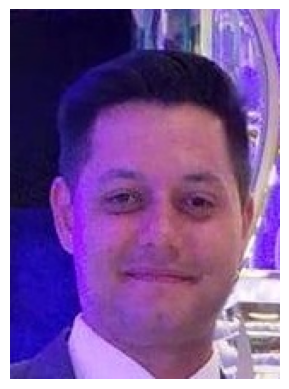

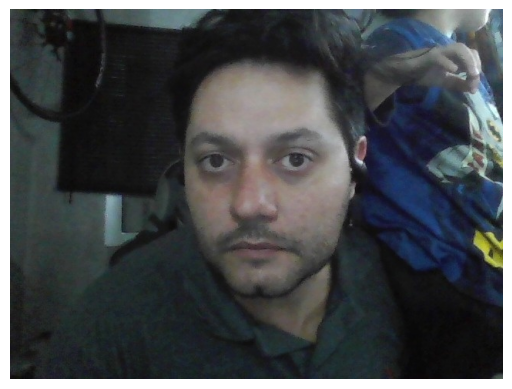

In [37]:
import cv2
from matplotlib import pyplot as plt

def exibir_imagem(imagem_path):
    img = cv2.imread(imagem_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# Exibir as imagens para verificação
exibir_imagem(foto1)
exibir_imagem(foto2)
